In [1]:
import os
# os.chdir('/Users/tud500158/Documents/github/AutomatedDamageDetection/scripts/train-vae/')
# print(os.getcwd())
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
workdir = os.path.join(homedir,'github/AutomatedDamageDetection/')
os.chdir(os.path.join(workdir,'scripts/train-vae/'))
import numpy as np
import tensorflow as tf
import glob
import geopandas as gpd
import json
import configparser 
from sklearn.manifold import TSNE
import rioxarray as rioxr
import xarray as xr
import os
import matplotlib.pyplot as plt
import dataset
import tiles as ts

# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import xarray as xr

print('---- modules imported')
os.chdir(workdir)


---- modules imported


In [2]:

# def parse_config(config):
#     """ Parse input arguments from dictionary or config file """
#     if not isinstance(config, dict):
#         parser = configparser.ConfigParser()
#         parser.read(config)
#         config = parser["train-VAE"]

#     catPath = config['catalogPath']
#     labPath = config['labelsPath']
#     outputDir = config['outputDirectory']
#     sizeTestSet = int(config['sizeTestSet'])
#     sizeValSet = int(config['sizeValidationSet'])
#     roiFile = config['ROIFile']
#     bands = [int(i) for i in config['bands'].split(" ")]
#     sizeCutOut = int(config['sizeCutOut'])
#     nEpochMax = int(config['nEpochMax'])
#     sizeStep = int(config['sizeStep'])
#     normThreshold = float(config['normalizationThreshold'])
        
#     return (catPath, labPath, outputDir, sizeTestSet, sizeValSet, roiFile,
#             bands, sizeCutOut, nEpochMax, sizeStep, normThreshold)


def parse_config(config):
    """ Parse input arguments from dictionary or config file """
    if not isinstance(config, dict):
        parser = configparser.ConfigParser(allow_no_value=True)
        parser.read(config)
        config = parser["train-VAE"]

    catPath = config['catalogPath']
    labPath = config['labelsPath']
    outputDir = config['outputDirectory']
    sizeTestSet = int(config['sizeTestSet'])
    sizeValSet = int(config['sizeValidationSet'])
    roiFile = config['ROIFile']
    #
    bands = [int(i) for i in config['bands'].split(" ")]
    sizeCutOut = int(config['sizeCutOut'])
    sizeStep = int(config['sizeStep'])
    stride = int(config['stride'])
    #DATA
    # balanceRatio = float(config['balanceRatio'])
    file_DMGinfo = config['tiledDamagePixelsCountFile']
    # normThreshold = [float(i) for i in config['normalizationThreshold'].split(" ")]
    normThreshold = config['normalizationThreshold']
    if normThreshold is not None:
        normThreshold = [float(i) for i in normThreshold.split(" ")]
    # MODEL
    filter1 = int(config['filter1'])
    filter2 = int(config['filter2'])
    kernelSize1 = int(config['kernelSize1'])
    kernelSize2 = int(config['kernelSize2'])
    denseSize = int(config['denseSize'])
    latentDim = int(config['latentDim'])
    #vae:
    alpha = float(config['alpha'])
    batchSize = int(config['batchSize'])
    nEpochMax = int(config['nEpochData'])
    nEpochTrain = int(config['nEpochTrain'])
    learnRate = float(config['learningRate'])
#     validationSplit = float(config['validationSplit'])

    return (catPath, labPath, outputDir, sizeTestSet, sizeValSet, roiFile,
            bands, sizeCutOut, nEpochMax, nEpochTrain, sizeStep, stride, file_DMGinfo, normThreshold,
            filter1, filter2, kernelSize1,kernelSize2, denseSize, latentDim,
            alpha, batchSize,learnRate)



In [3]:

# # path_to_traindir = './model_v0/train_epoch_2/' # path on local computer
# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-12') # path on local computer
# # path_to_traindir = './train/model_v0/train_epoch_2/' # path on cartesius
ini_file = 'train-vae.ini'

# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-12') # path on local computer
# model_dir = 'model_1652389459' # VAE-b-L2-n2
# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-19') # path on local computer
# model_dir = 'model_1652994000' # VAE-b-L2-n20
# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-19') # path on local computer
# model_dir = 'model_1652995389' # VAE-b-L4-n2

# -- OKTOBER
# path_to_traindir = os.path.join(workdir, 'training','2022-10') # path on local computer
# # model_dir = 'model_1664876184' # VVAE with hist-equal input; applied to windows
# model_dir = 'model_1665487140' # VAE with hist-equal input; applied to img, alpha=2000

# path_to_traindir = os.path.join(workdir, 'training','2022-10/2022-10-04') # path on local computer
# model_dir = 'model_1664891181' # VAE with hist-equal input: applied to windows --> higher alpha


# -- NOV
path_to_traindir = os.path.join(workdir,'training','2022-11','2022-11-03')
model_dir = 'model_1667483750' # 3 nov
# model_dir = 'model_1667487343' # 3 nov

# ---------
config = os.path.join(path_to_traindir,model_dir,'train-vae.ini')

catPath, labPath, outputDir, sizeTestSet, sizeValSet, roiFile, \
        bands, cutout_size, nEpochmax, nEpochTrain, sizeStep, stride, file_DMGinfo, normThreshold, \
        filter1, filter2, kernelSize1, kernelSize2, denseSize, latentDim, \
        alpha, batchSize,learnRate = parse_config(config)
            

# local maachine: overwrite caatalogpath and labelspath
# catalog_path = '/Users/tud500158/Documents/Data/tiles'
# labels_path ='/Users/tud500158/Documents/PhD/crevasseDetection/GoogleEarth/labels/geojson/EPSG4326/'
catalog_path = os.path.join(homedir,'Data/tiles')
labels_path =os.path.join(homedir,'PhD/crevasseDetection/GoogleEarth/labels/geojson/EPSG4326/')


In [4]:
os.path.join(path_to_traindir , 'model*')
glob.glob(os.path.join(path_to_traindir , model_dir))
# path_to_traindir

['/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2022-11/2022-11-03/model_1667483750']

In [8]:

''' ----------
Load model
------------'''


path_to_model = glob.glob(os.path.join(path_to_traindir , model_dir))
print(path_to_model)
path_to_model = path_to_model[0]
# epoch_dirs = glob.glob(path_to_model +'/epoch*' )
epoch_dirs = glob.glob(path_to_model +'/model_epoch*' )
encoder_dirs = glob.glob(path_to_model+'/encoder*')
epoch_dirs.sort()
encoder_dirs.sort()
path_to_model_epoch = epoch_dirs[-1]
path_to_encoder_epoch = encoder_dirs[-1]

print(path_to_model_epoch)
print(path_to_encoder_epoch)

model = tf.keras.models.load_model(path_to_model_epoch ,compile=False)
encoder = tf.keras.models.load_model(path_to_encoder_epoch)#,compile=False)

# Get latent_dim (of sampling layer)
latent_dim = encoder.layers[-1].output_shape[-1] # is 4


print('---- loaded model, encoder and .ini')


['/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2022-11/2022-11-03/model_1667483750']
/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2022-11/2022-11-03/model_1667483750/model_epoch_1
/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2022-11/2022-11-03/model_1667483750/encoder_epoch_1
---- loaded model, encoder and .ini


In [6]:
# encoder2 =tf.keras.models.load_model(path_to_encoder_epoch,compile=True)
# encoder2.compile()
# encoder

In [7]:
# help(tf.keras.models.load_model)
# model2 = tf.keras.models.load_model(path_to_model_epoch ,compile=True)
# # model2.summary()
# model2.layers

In [24]:
testPath = os.getcwd()
thePath, fname = os.path.split(testPath)
os.path.split(testPath)[-1]

'AutomatedDamageDetection'

In [8]:
# # Check encoder info
# path_to_encoder_epoch
# help(encoder.save)

# Data

In [9]:


''' ----------
Get testdata: one tile

Instead of loading tiles directly as tf Dataset with dataset.Dataset(), load the tile as xarray to be able to link it to labels
------------'''

# get info on which tiles are assigned as test tiles
datasets_json = glob.glob(os.path.join(path_to_traindir, model_dir , 'datasets*.json'))

with open(datasets_json[0]) as file:        # Opening JSON file
    datasets_dict = json.loads(file.read()) # load data

test_set_paths = datasets_dict['test']   
# print(test_set_paths)

'''
TMP: test with training tiles to see how well damage is represented in latent space

'''

train_set_paths = datasets_dict['training']   

# test: 1 tile
# num_tiles = 1 # number of tiles to load
# tile_list = test_set_paths[:num_tiles];
# print('tilelist: ' , tile_list)

tile_list = train_set_paths

# update tile_list to be for local machine
tile_names = [tile_n.split('/')[-1] for tile_n in tile_list]
# tile_path_local = pathlib.Path('/Users/tud500158/Documents/Data/tiles/')
tile_path_local = os.path.join(homedir,'Data/tiles/training_tiles/')

tile_list_local = [os.path.join(tile_path_local,tile_name) for tile_name in tile_names]

# tiles that are actually on my local machine
tiles_on_machine = glob.glob(os.path.join(tile_path_local , '*.tif'))

# remake tile_list 
tile_list = []
for tile in tiles_on_machine:
    if tile in tile_list_local:
        tile_list.append(tile)
tile_list        

['/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_250.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_285.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_291.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_268.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_t

In [10]:
# os.listdir(tile_path_local)

In [10]:

''' ----------
tmp: select 1 tile as tilelist
------------'''
# tile_list = [tile_list[1]]
# tile_list = [tile_list[-1]]
# tile_list

tile_file = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif',



In [11]:


''' ----------
Get Labels
------------'''


# # read tile catalog to be able to get CRS and filter labels to same date
catalog = ts._read_tile_catalog(catalog_path)
tiles = ts._catalog_to_geodataframe(catalog)

labels = ts._read_labels(labels_path, verbose=True)
labels = labels.to_crs(tiles.crs)  # make sure same CRS is used
# select the only labels matching the tiles timespan
labels = ts._filter_labels(labels,
                        tiles.start_datetime.min(),
                        tiles.end_datetime.max())


## Create GeoSeries from labels.geometry
label_polys = gpd.GeoSeries(labels.geometry,crs=labels.crs) # Combine all geometries to one GeoSeries, with the 


Labels successfully read from 16 files
Selecting 627 out of 905 labels


In [13]:
# # path to files
# data_dir = os.path.join(homedir, 'Data')
# # path_to_dmg = os.path.join(data_dir, 'RAMP/RAMP_tiled/damage_detection/geotiffs')
# path_to_dmg = os.path.join(data_dir, 'tiles/damage_detection/geotiffs')
# dmg_files = glob.glob(path_to_dmg + '/*damage*.tif')
# # dmg_files = [file.split('/')[-1] for file in dmg_files]
# dmg_files
# # path_to_dmg

In [14]:

# # tile_list[0]
# # print(tile_list[0])
# # tileName = tile_list[0].split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
# # tileNum = 'tile_' + tileName.split('_')[-1]
# # print(tileNum)
# # file_dmg = [fname for fname in dmg_files if tileNum in fname] # filenae of tile withuot path
# # file_dmg

# tileNum='tile_140'
# file_dmg = glob.glob(path_to_dmg  + '/*'+ tileNum + '*damage*' )
# file_dmg

In [12]:
'''  ----------------
get tile nd corresponding NERD dmg (ipv labels)
----------------- '''

# path to files
# data_dir = os.path.join(os.path.expanduser('~'), 'Documents/Data')
data_dir = os.path.join(homedir, 'Data')
# path_to_dmg = os.path.join(data_dir, 'RAMP/RAMP_tiled/damage_detection/geotiffs')
path_to_dmg = os.path.join(data_dir, 'tiles/damage_detection/geotiffs')
dmg_files = glob.glob(path_to_dmg + '/*damage*.tif')
dmg_files = [file.split('/')[-1] for file in dmg_files]

print(dmg_files)

['S2_composite_2019-11-1_2020-3-1_tile_124_300m_damageContin.tif', 'S2_composite_2019-11-1_2020-3-1_tile_140_300m_damageContin.tif']


In [13]:

from skimage import exposure as skimage_exposure



def get_tile_with_dmg(tile):
    tileName = tile.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
    tileNum = 'tile_' + tileName.split('_')[-1]
    # print(tileNum)
    
    # read tile - floats are required to mask with NaN's
    tile_da = rioxr.open_rasterio(tile).astype("float32")

    file_dmg = [fname for fname in dmg_files if tileNum in fname] # filenae of tile withuot path
    # print(type(file_dmg))
    
    tile_dmg = rioxr.open_rasterio(os.path.join(path_to_dmg, file_dmg[0])).astype("float32")
  
    # interpolate dmg to same resolution as tile (to link as labels)
    tile_dmg_int = tile_dmg.isel(band=0).interp_like(tile_da.isel(band=0))
    tile_dmg_int= tile_dmg_int.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim

    return tileNum, tile_da, tile_dmg, tile_dmg_int


def plot_tile_and_dmg(tile_da, tile_dmg):
    tile_img = tile_da.transpose('x','y','band')
    
    fig, (ax1,ax2) = plt.subplots(1,2)
    # plt.imshow(tile_img[:,:,0:3].astype('uint8'),vmin=1000,vmax=15000)
    ax1.imshow(tile_img[:,:,2])
    
def create_cutouts(da,cutout_size, normThreshold=None, equalise=False):
    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        n_bands = da['band'].shape[0]
        all_band_eq=np.empty(da.shape)

        for band_i in range(n_bands): # perform adaptive normalisation per band
            band_data = da.isel(band=band_i)
            band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
            all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

        da = da.copy(data=all_band_eq) # overwrite data in dataArray

    tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    tile_cutouts_da = da.transpose('sample','x_win','y_win','band')

    return tile_cutouts, tile_cutouts_da

def normalise_and_equalise(da,normThreshold=None,equalise=False):
    
    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        n_bands = da['band'].shape[0]
        all_band_eq=np.empty(da.shape)

        for band_i in range(n_bands): # perform adaptive normalisation per band
            band_data = da.isel(band=band_i)
            band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
            all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

        da = da.copy(data=all_band_eq) # overwrite data in dataArray
    
    return da
    
def create_cutouts2(da,cutout_size):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    tile_cutouts_da = da.transpose('sample','x_win','y_win','band')

    return tile_cutouts, tile_cutouts_da

# # for tile in tile_list:    
# # tile_file = tile_list[0]
# tile_file = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif'
# # tile_file = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_140.tif'
# tileNum, tile_da, tile_dmg, tile_dmg_int = get_tile_with_dmg( tile_file )
# # tileNum, tile_da, tile_dmg, tile_dmg_int = get_tile_with_dmg( tile_list )
# # tile_img = tile_da.transpose('x','y','band')

# print(tile_dmg.shape,
#      tile_da.shape,
#      tile_dmg_int.shape)

In [12]:
dmg_files 

['S2_composite_2019-11-1_2020-3-1_tile_124_300m_damageContin.tif',
 'S2_composite_2019-11-1_2020-3-1_tile_140_300m_damageContin.tif']

# Read data, Create cutouts

In [14]:
# mask ROI (ocean)
import geopandas as gpd

# if self.mask is not None:
#     mask = self.mask.to_crs(da.spatial_ref.crs_wkt)
#     geometry = mask.unary_union.buffer(self.buffer)
#     # da = da.rio.clip([geometry], drop=True, invert=self.invert,
#     #                  all_touched=self.all_touched)
#     da = da.rio.clip([geometry], drop=False, invert=self.invert, # if mask defined, do not drop
#                      all_touched=self.all_touched)
def mask_data(data, mask_file):
    mask_poly = gpd.read_file(mask_file).to_crs(epsg=3031)
    # gdf = mask_poly.unary_union 
    # mask = data #.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
    masked_data = data.rio.clip(mask_poly.unary_union, mask_poly.crs, drop=False, invert=False) # mask (raster)
    return masked_data


In [16]:

''' ----------
Create cut-outs
    Actually read the tile, make cutouts, linked with labeldata
    
Update: do not link laabldata; now read same-tile NERD output
------------'''


''' ----------
Get tile
------------'''

# tile 124 is a training tile
tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif')
dmg_file = os.path.join(path_to_dmg, 'S2_composite_2019-11-1_2020-3-1_tile_124_300m_damageContin.tif')
# tile 285 is also a training t ile
# tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_285.tif')
# tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_110.tif')
# tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_50.tif')

mask_file = os.path.join(homedir,'Data/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp')    


tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
print('\n----\n Processing ' + tileName +'\n')

# read tile - floats are required to mask with NaN's
da = rioxr.open_rasterio(tile_file).astype("float32")

# select bands
if bands is not None:
    if type(bands) is not list:
        da = da.sel(band=[bands])
    else:
        da = da.sel(band=bands)


''' ----------
Get DMG
------------'''
tile_dmg = rioxr.open_rasterio(os.path.join(path_to_dmg, dmg_file)).astype("float32")

# interpolate dmg to same resolution as tile (to link as labels)
tile_dmg_int = tile_dmg.isel(band=0).interp_like(da.isel(band=0))
tile_dmg_int= tile_dmg_int.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim
    
''' ----------
Mask ocean
------------'''
# mask/clip: if self.mask is not None: [removed; see _generate_cutouts]
da_origin = da.copy()
# da = mask_data(da,mask_file)
# da_mask = da.copy()

''' ----------
Normalise and Equalise
------------'''

# da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=False)
# da_norm_equal = da.copy()

''' ----------
Create cut-outs
------------'''

# generate windows -- cut 

tile_cutouts, tile_cutouts_da = create_cutouts2(da,cutout_size) # samples, x_win, y_win, bands: (250000, 20, 20, 1)
label_cutouts, __ = create_cutouts2(tile_dmg_int, cutout_size)

print(tile_cutouts.shape)
print(label_cutouts.shape)




----
 Processing S2_composite_2019-11-1_2020-3-1_tile_124

(15625, 100, 100, 3)
(15625, 100, 100, 1)


In [38]:
# create_cutouts2(tile_dmg_int, cutout_size)

In [18]:
print(label_cutouts.shape)

xr.concat([da, tile_dmg_int],'newDim')

(15625, 100, 100, 1)


<xarray.DataArray (newDim: 2, band: 3, y: 12505, x: 12502)>
array([[[[ 7913.,  7913.,  9288., ...,  8992.,  9080.,  9080.],
         [ 7381.,  8200.,  9087., ...,  8992.,  8992.,  8976.],
         [ 7968.,  7968.,  8641., ...,  9104.,  9040.,  8952.],
         ...,
         [   15.,    40.,    54., ...,  9096.,  9016.,  8968.],
         [  131.,   206.,   248., ...,  8920.,  9016.,  8976.],
         [  158.,   173.,   391., ...,  8952.,  8968.,  9056.]],

        [[ 8832.,  8832.,  9728., ...,  9304.,  9320.,  9360.],
         [ 7752.,  8568.,  9552., ...,  9216.,  9216.,  9224.],
         [ 8817.,  8817.,  8834., ...,  9344.,  9184.,  9280.],
         ...,
         [   96.,   170.,   171., ...,  9304.,  9264.,  9216.],
         [  159.,   304.,   260., ...,  9296.,  9304.,  9264.],
         [  263.,   460.,   191., ...,  9216.,  9272.,  9304.]],

        [[ 8887.,  8887., 10143., ...,  9328.,  9376.,  9400.],
         [ 7535.,  9126.,  9815., ...,  9248.,  9248.,  9360.],
         [ 8623.,  8623.,  9415., ...,  9360.,  9304.,  9360.],
         ...,
...
         ...,
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]]]])
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 -7.5e+05 -7.5e+05 -7.5e+05 ... -6.25e+05 -6.25e+05
  * y            (y) float64 1.625e+06 1.625e+06 1.625e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 0
Dimensions without coordinates: newDim
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first', 'B11_first')

In [ ]:
print('nandata in:')
print('da original: {} \n da masked: {} \n da norm/equal: {} '.format(np.isnan(da_origin).any().values, np.isnan(da_mask).any().values, np.isnan(da_norm_equal).any().values ))

In [ ]:
nanmask = np.isnan(da)

In [ ]:
fig,ax= plt.subplots(1,2,figsize=(10,8))
da_origin.attrs['long_name']='imgbands';
da_origin.isel(band=0).plot.imshow(ax=ax[0])
ax[0].set_title('img, not normalised')
da_norm_equal.isel(band=0).plot.imshow(ax=ax[1],vmin=0,vmax=1,cbar_kwargs={"fraction": 0.046})
ax[1].set_title('img, normalised and equalised')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

In [19]:

''' ----------
Encode input 
------------'''
encoded_data_file = os.path.join(path_to_model, tileName + "_encoded.npy")
if os.path.exists(encoded_data_file):
    # read file
    encoded_data = np.load(encoded_data_file)
    print('---- loaded encoded data; size: ', encoded_data.shape)
else: 
    # encode data and save file
    encoded_data,_,_ = encoder.predict(tile_cutouts);
    np.save(encoded_data_file, encoded_data) # save encoded data for later use.
    # np.save(tileName + "_labels.npy", label_cutouts) # save encoded data for later use.
    print('---- succesfully encoded data; size: ', encoded_data.shape)



---- succesfully encoded data; size:  (15625, 4)


In [23]:
print("min/max \n tile_cutouts: {:.1f},{:.1f} \n encoded_data: {:.1f},{:.1f}".format(tile_cutouts.min(), tile_cutouts.max(), encoded_data.min(), encoded_data.max()))

min/max 
 tile_cutouts: 0.0,1.0 
 encoded_data: -0.0,0.0


Text(0.5, 1.0, 'histogram of latent space parameters')

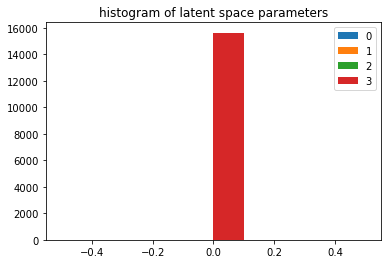

In [24]:
# encoded_data.min()
# encoded_data.max()
plt.figure()
for ldim in range(0, encoded_data.shape[1]):
    plt.hist(encoded_data[:,ldim],label=ldim)
plt.legend()    
plt.title('histogram of latent space parameters')

In [25]:

''' ----------
predict output  
------------'''

# predicted_data = model.predict(tile_cutouts); # reconstruct images (windows):
# np.save(os.path.join(path_to_model, tileName + "_predicted.npy"),predicted_data)
# print('---- succesfully predicted data')


' ----------\npredict output  \n------------'

In [25]:
tile_cutouts_da.attrs['long_name'] = 'bands'
tile_cutouts_da.attrs

{'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': 'bands'}

In [26]:
tileName

tileNum='tile_'+tileName.split('tile_')[-1]
tileNum

'tile_50'

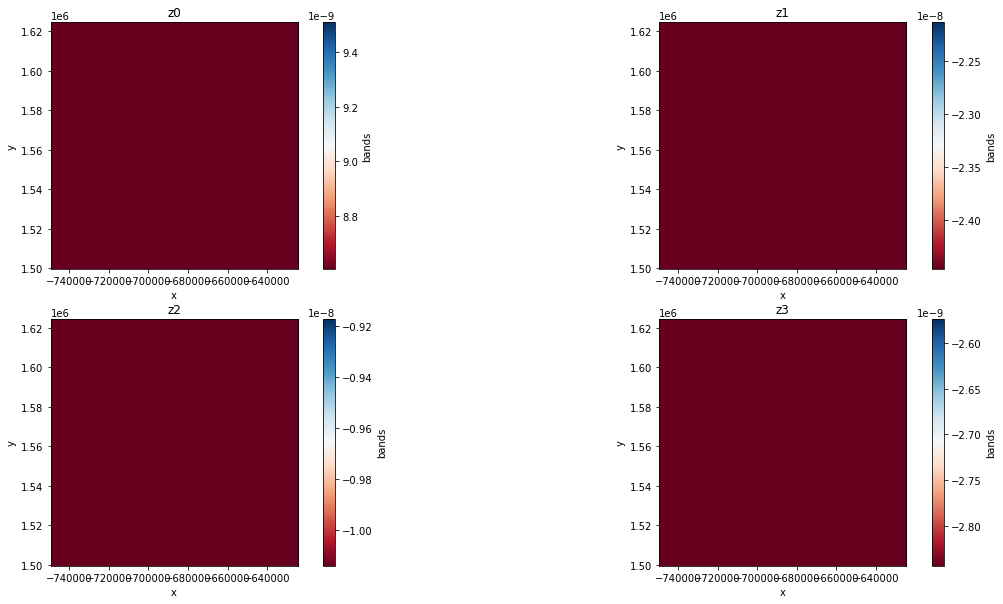

In [26]:

''' ----------
Plot latent space spatially Ldim=4
------------'''

if latent_dim == 4:
    z0 = encoded_data[:,0]
    z1 = encoded_data[:,1]
    z2 = encoded_data[:,2]
    z3 = encoded_data[:,3]



    # add z0 only to (sample,x,y. )
    L_space_xy_z0 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z0,axis=1) ) #.unstack()
    L_space_xy_z1 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z1,axis=1) ) #.unstack()
    L_space_xy_z2 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z2,axis=1) ) #.unstack()
    L_space_xy_z3 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z3,axis=1) ) #.unstack()


    fig,axes = plt.subplots(2,2,figsize=(20,10))

    # axes[0,0].imshow(tile_da[0])
    # axes[0,0].set_aspect('equal')
    # tile_data.isel(band=0).plot.imshow()#ax=axes[0],x='x',add_label=False)

    L_space_xy_z0.unstack().isel(band=0).plot.imshow(ax=axes[0,0],x='x',cmap='RdBu') #,vmin=-0.1,vmax=0.1, # vmin=-2 vmax=2
    axes[0,0].set_title('z0')
    axes[0,0].set_aspect('equal')


    L_space_xy_z1.unstack().isel(band=0).plot.imshow(ax=axes[0,1],x='x',cmap='RdBu') # vmin=-0.1,vmax=0.1,
    axes[0,1].set_title('z1')
    axes[0,1].set_aspect('equal')


    L_space_xy_z2.unstack().isel(band=0).plot.imshow(ax=axes[1,0],x='x',cmap='RdBu') # vmin=-2 vmax=2
    axes[1,0].set_title('z2')
    axes[1,0].set_aspect('equal')


    L_space_xy_z3.unstack().isel(band=0).plot.imshow(ax=axes[1,1],x='x',cmap='RdBu') # vmin=-2 vmax=2
    axes[1,1].set_title('z3')
    axes[1,1].set_aspect('equal')

    # fig.savefig(os.path.join(path_to_traindir , model_dir, 'spatial_lspace_' + tileNum))

# Plot encoded representation

We can also have a look at the 128-dimensional encoded representations. 
These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

In [29]:
encoded_data.shape


(15625, 4)

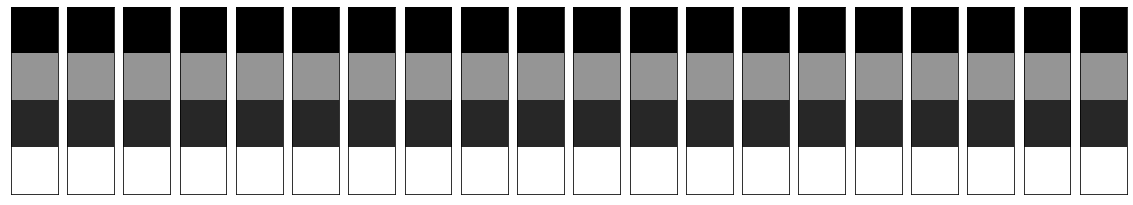

In [30]:
# encoder = keras.Model(input_img, encoded)
# encoded_imgs = encoder.predict(x_test)

n = 20
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_data[i+1000].reshape((1, 4)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Embed latent space

In [64]:
'''  ----------------
embed latentspace to 2D for cluster plot 
----------------- '''

def embed_latentspace_2D(encoded_data,
                         latent_dim,perplexity=10, 
                         n_iter=1000,
                         n_iter_without_progress=300):
    ''' Consider using perplexity between 5 and 50 (default 30); larger datasets usually require a larger perplexity.
        n_iter default 1000, should be at least 250
        learning_rate: the learning rate for t-SNE is usually in the range [10.0, 1000.0], default=200; The ‘auto’ option sets the learning_rate to max(N / early_exaggeration / 4, 50)
    '''
    
    z_mean_2D = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=n_iter,
                     learning_rate='auto',
                     init='pca',
                     n_iter_without_progress=n_iter_without_progress).fit_transform(encoded_data);

    return z_mean_2D

Nsamples = encoded_data.shape[0] #100000 


if latent_dim > 2: 
    encoded_2D_testdata = embed_latentspace_2D(encoded_data, # sample selection
                                           latent_dim,perplexity=40,
                                           n_iter=250,
                                           n_iter_without_progress=100)

# np.save("embedded_data_N{:d}_tileX.npy".format(Nsamples),reconstructed_window)
# z_mean_2D = TSNE(n_components=2,
#                  perplexity=30,
#                  n_iter=250,
#                  init='pca',
#                  n_iter_without_progress=100,
#                  n_jobs=4).fit_transform(encoded_data);
# np.save("embedded_data_N_tileX.npy",encoded_2D_testdata)
print('---- succesfully embedded data of {} dim to 2D'.format(latent_dim))
 

    
print('\n')

/Users/tud500158/opt/anaconda3/envs/VAEenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


---- succesfully embedded data of 4 dim to 2D




In [32]:

print('---- succesfully embedded data of {} dim to 2D'.format(latent_dim))

---- succesfully embedded data of 4 dim to 2D


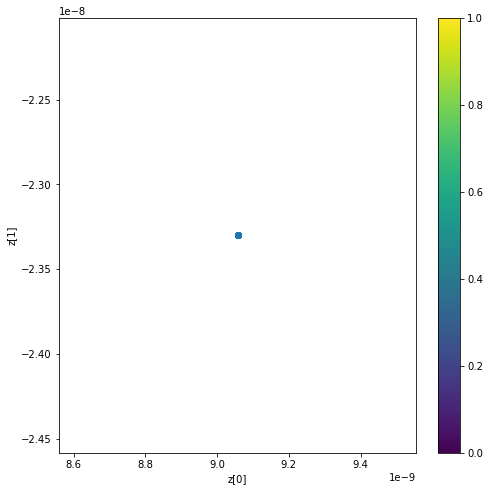

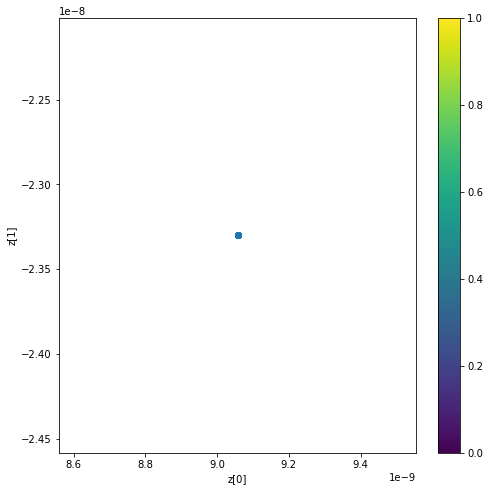

In [30]:

import matplotlib.colors as colors

''' ----------
Plot clustering
------------'''
  
    

def plot_latentspace_clusters_no_labels( embedded_data ):#,labels):
    ''' Embedded data should have (N,2)'''
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1])#, c=labels,s=2,cmap='winter') # also add size for scatter point
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    return fig
    


# fig = plot_latentspace_clusters_no_labels( embedded_data[:,0:2] )
# fig.savefig(os.path.join(path_to_traindir , model_dir, 'embedded_testdata_nolabels_' + tileNum))


Text(0, 0.5, 'z1')

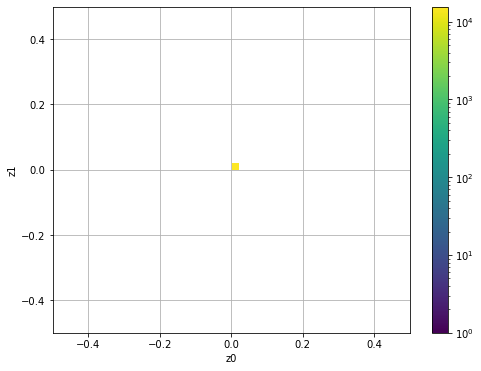

In [31]:
# PLOT HEATMAP
''' -- get latent spaace features  '''
# tile_cutouts_balanced.shape # ('sample', 'x_win', 'y_win', 'band')
# tile_cutout_da = tile_da.transpose('sample','x_win','y_win','band')
train_samples_unstacked = tile_cutouts_da.unstack()

# To interpret clusters: extract z0 and z1 values to plot spatially. 
embedded_data = encoded_data # 2D

z0 = embedded_data[:,0]
z1 = embedded_data[:,1]
 

''' -- plot  '''
heatmap, xedges, yedges = np.histogram2d(z0, z1, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig,ax=plt.subplots(1,figsize=(8,6))
# ax = fig.add_subplot(132)
hmap = ax.imshow(heatmap.T, extent=extent, origin='lower',norm=colors.LogNorm(vmin=1, vmax=heatmap.max()),cmap='viridis')
ax.set_aspect('auto')
ax.grid('on')
fig.colorbar(hmap)
ax.set_xlabel('z0')
ax.set_ylabel('z1')


# fig.savefig(os.path.join(path_to_traindir , model_dir, 'embedded_testdata_heatmap_' + tileNum))

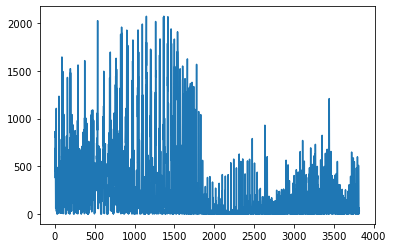

In [45]:
# plt.figure()
# plt.hist(labels_encoded)

labels_encoded = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, 20, 20, 1) to (Nsamples,1)
# plt.plot(labels_encoded)

val = labels_encoded[labels_encoded > 0]
plt.plot(val)

In [52]:
labels_encoded.shape

(15625, 1)

[   0.            0.            0.         ... 2066.38490516 2071.34734574
 2071.82363613]
(15625,)


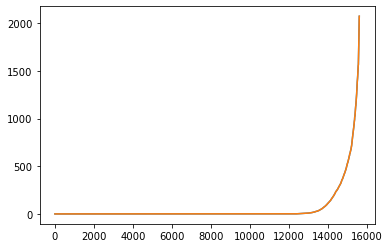

In [62]:
lsort = np.sort(labels_encoded.squeeze(),axis=0 )
print(lsort)
isort = np.argsort(labels_encoded.squeeze(),axis=0)
print(isort.shape)
plt.plot(lsort)
plt.plot(labels_encoded[isort])

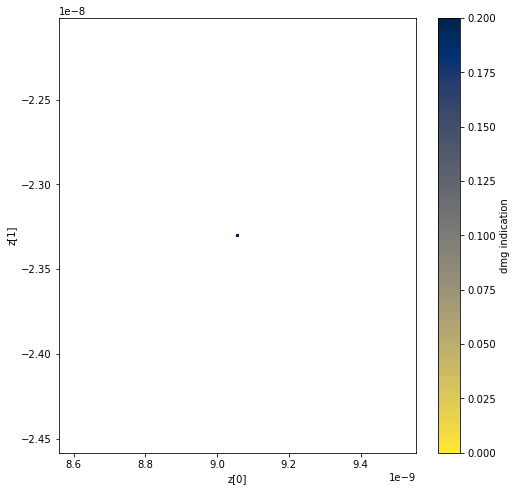

In [63]:

    
def plot_latentspace_clusters( embedded_data,labels, clabel ):    
    marksize = 2
    # print(embedded_data.shape)
    if len(labels.shape)>1:
        labels = np.squeeze(labels)
    
    
    # sort data with label value
    embedded_data = embedded_data[ np.argsort(labels),:] #,np.argsort(labels)]
    labels = np.sort(labels,axis=0)
    
    # embedded_data = embedded_data[ np.argsort(labels),:] #,np.argsort(labels)]
    z0 = embedded_data[:, 0]
    z1 = embedded_data[:, 1]
    # z0_label1 = z0[ labels > 0]
    # z0_label0 = z0[ labels ==0]
    # z1_label1 = z1[ labels > 0]
    # z1_label0 = z1[ labels ==0]
    
    
    fig, ax1 = plt.subplots(figsize=(8,8) )
    s1 = ax1.scatter(z0, z1, c=labels, s=marksize, cmap='cividis_r',vmin=0, vmax=0.2) # also add size for scatter point
    # s0 = ax1.scatter(z0_label0, z1_label0, color='red', s=marksize, ) # also add size for scatter point
    # s1 = ax1.scatter(z0_label1, z1_label1, c=labels[labels>0], s=marksize, cmap='cividis_r',vmin=0, vmax=0.2) # also add size for scatter point
    ax1.set_xlabel("z[0]"); 
    ax1.set_ylabel("z[1]");
    fig.colorbar(s1,ax=ax1,label=clabel);
    return fig

labels_encoded = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, 20, 20, 1) to (Nsamples,1)
# encoded_2D_testdata.shape
fig = plot_latentspace_clusters( embedded_data[:,0:2] , labels_encoded ,clabel='dmg indication')

# fig.savefig(os.path.join(path_to_traindir , model_dir, 'embedded_testdata_label_' + tileNum))


In [ ]:

# ''' ----------
# Plot latent space spatially
# ------------'''

# if latent_dim <=2:

#     # must expand 1D array (Nsamples,) to (Nsamples,20,20) to spatially represent each window.
#     # use np.repeaat or np.tile
#     x = np.array([1,2,3,4]).T
#     z0_win = np.expand_dims(z0,axis=1) 
#     z0_win = np.expand_dims(z0_win,axis=2) # (Nsamples,20,20) filled with the same sample-value on every pixel in the (20,20) window
#     z0_win = np.repeat(z0_win, 20, axis=1)
#     z0_win = np.repeat(z0_win ,20, axis=2) 
#     # z0_win



#     # L_space_unstacked = tile_cutout_da.isel(band=[0]).copy(deep=True, data=np.expand_dims(z0_win,axis=3) ).unstack()
#     # L_space_unstacked
#     # fig = L_space_unstacked.isel(x=1,y=1,band=0).plot.imshow()


#     # add z0 only to (sample,x,y. )
#     L_space_xy_z0 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z0,axis=1) ) #.unstack()
#     L_space_xy_z0

#     # add z1 only to (sample,x,y. )
#     L_space_xy_z1 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z1,axis=1) ) #.unstack()

#     # L_space_xy_labels = tile_cutout_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(labels,axis=1) ) #.unstack()



#     # plt.imshow(labels_raster[0])


#     fig,axes = plt.subplots(1,3,figsize=(20,5))

#     axes[0].imshow(tile_da[0])
#     axes[0].set_aspect('equal')
#     # tile_data.isel(band=0).plot.imshow()#ax=axes[0],x='x',add_label=False)

#     L_space_xy_z0.unstack().isel(band=0).plot.imshow(ax=axes[1],x='x',vmin=-3,vmax=3,cmap='RdBu') # vmin=-2 vmax=2
#     axes[1].set_title('z0')
#     axes[1].set_aspect('equal')


#     L_space_xy_z1.unstack().isel(band=0).plot.imshow(ax=axes[2],x='x',vmin=-0.01,vmax=0.01,cmap='RdBu')
#     axes[2].set_title('z1')
#     axes[2].set_aspect('equal')



#     fig.savefig(os.path.join(path_to_traindir , model_dir, 'spatial_lspace_' + tileNum))